In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [2]:
from datasets import load_dataset
dataset = load_dataset("squad")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from transformers import BertTokenizerFast

In [4]:
train_data = dataset["train"]
val_data = dataset["validation"]

In [5]:
# Print the first sample
sample = train_data[0]
for key, value in sample.items():
    print(f"{key.upper()}:\n{value}\n")



ID:
5733be284776f41900661182

TITLE:
University_of_Notre_Dame

CONTEXT:
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

QUESTION:
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

ANSWERS:
{'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}



In [6]:
context = sample["context"]
answer_text = sample["answers"]["text"][0]
answer_start = sample["answers"]["answer_start"][0]

# Extract substring from context and compare
extracted_text = context[answer_start : answer_start + len(answer_text)]

print("ANSWER TEXT:", answer_text)
print("EXTRACTED:", extracted_text)
print("Match:", answer_text == extracted_text)


ANSWER TEXT: Saint Bernadette Soubirous
EXTRACTED: Saint Bernadette Soubirous
Match: True


In [7]:
unique_titles = set([sample["title"] for sample in train_data])
print(f"Unique topics in training set: {len(unique_titles)}")


Unique topics in training set: 442


In [8]:
answer_counts = Counter([len(sample["answers"]["text"]) for sample in train_data])
print(answer_counts)


Counter({1: 87599})


#Advanced Tokenization with BERT


##Starting here

In [9]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define tokenization function
def tokenize_batch(batch):
    return tokenizer(
        batch['question'],
        batch['context'],
        truncation=True,
        padding="max_length",
        max_length=384,
    )

# Get columns to remove (same for all splits)
columns_to_remove = dataset["train"].column_names

# Tokenize each split (train, validation, etc.)
tokenized_datasets = {
    split: dataset[split].map(
        tokenize_batch,
        batched=True,
        remove_columns=columns_to_remove
    )
    for split in dataset
}

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [11]:
from transformers import AutoModelForQuestionAnswering, DataCollatorWithPadding

# Load a pre-trained model for QA
model = AutoModelForQuestionAnswering.from_pretrained("bert-base-uncased")

# Create a data collator (for dynamic padding during training)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from tqdm import tqdm

In [13]:
class LearnGPT(nn.Module):
    def __init__(self, vocab_size):
        super(LearnGPT, self).__init__()
        from transformers import BertModel
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.qa_outputs = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # (batch_size, seq_len, hidden)
        logits = self.qa_outputs(sequence_output)    # (batch_size, seq_len, 2)
        start_logits, end_logits = logits.split(1, dim=-1)
        return start_logits.squeeze(-1), end_logits.squeeze(-1)

In [14]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [15]:
# Sample encoding function for one example (returns dict of lists)
def encode_sample_fast(sample, tokenizer, max_len=384):
    question = sample["question"]
    context = sample["context"]
    answer_text = sample["answers"]["text"][0]
    answer_start = sample["answers"]["answer_start"][0]

    inputs = tokenizer(
        question,
        context,
        max_length=max_len,
        truncation="only_second",
        padding="max_length",
        return_offsets_mapping=True
    )

    offset_mapping = inputs.pop("offset_mapping")
    start_char = answer_start
    end_char = answer_start + len(answer_text)

    start_token = end_token = 0
    for idx, (start, end) in enumerate(offset_mapping):
        if start <= start_char < end:
            start_token = idx
        if start < end_char <= end:
            end_token = idx
            break

    # Edge case: if answer token not found
    if start_token == 0 and end_token == 0:
        start_token = end_token = 0

    inputs["start_position"] = start_token
    inputs["end_position"] = end_token
    return inputs

In [16]:
# Encode your dataset (replace `train_data` and `val_data` with actual lists)
encoded_train = [encode_sample_fast(sample, tokenizer) for sample in train_data]
encoded_val = [encode_sample_fast(sample, tokenizer) for sample in val_data]

In [17]:
# PyTorch dataset
class QADataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        item = {
            "input_ids": torch.tensor(self.encodings[idx]["input_ids"]),
            "attention_mask": torch.tensor(self.encodings[idx]["attention_mask"]),
            "start_positions": torch.tensor(self.encodings[idx]["start_position"]),
            "end_positions": torch.tensor(self.encodings[idx]["end_position"]),
        }
        return item

In [18]:
# Datasets & Dataloaders
train_dataset = QADataset(encoded_train)
val_dataset = QADataset(encoded_val)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [19]:
# Model setup
vocab_size = tokenizer.vocab_size
model = LearnGPT(vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [20]:
# Optimizer & Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Early stopping setup
patience = 3
best_val_loss = float("inf")
epochs_no_improve = 0

train_losses = []
val_losses = []

In [21]:
# Training loop
for epoch in range(1, 11):  # up to 10 epochs
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        start_logits, end_logits = model(input_ids, attention_mask=attention_mask)

        loss_start = criterion(start_logits, start_positions)
        loss_end = criterion(end_logits, end_positions)
        loss = (loss_start + loss_end) / 2

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} - Avg Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch} - Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            start_logits, end_logits = model(input_ids, attention_mask=attention_mask)

            loss_start = criterion(start_logits, start_positions)
            loss_end = criterion(end_logits, end_positions)
            loss = (loss_start + loss_end) / 2
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch} - Avg Validation Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Best model saved.")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("⏹️ Early stopping triggered.")
        break


Epoch 1 - Training: 100%|██████████| 10950/10950 [1:44:43<00:00,  1.74it/s]


Epoch 1 - Avg Training Loss: 1.5627


Epoch 1 - Validation: 100%|██████████| 1322/1322 [04:00<00:00,  5.49it/s]


Epoch 1 - Avg Validation Loss: 1.2227
✅ Best model saved.


Epoch 2 - Training:   2%|▏         | 233/10950 [02:14<1:43:22,  1.73it/s]


KeyboardInterrupt: 

In [28]:
from google.colab import files
files.download("best_model.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

import torch
from transformers import BertModel, BertTokenizerFast

# Load tokenizer (ensure it's the same as used during training)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Define the model architecture (must match the saved model)
class LearnGPT(torch.nn.Module):
    def __init__(self, vocab_size):
        super(LearnGPT, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.qa_outputs = torch.nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        return start_logits.squeeze(-1), end_logits.squeeze(-1)

# Load the saved model
vocab_size = tokenizer.vocab_size  # Ensure vocab_size matches training
model = LearnGPT(vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.load_state_dict(torch.load("best_model.pt", map_location=device)) # Load the model's state dictionary
model.eval() # Set the model to evaluation mode

print("Model loaded successfully!")


Model loaded successfully!


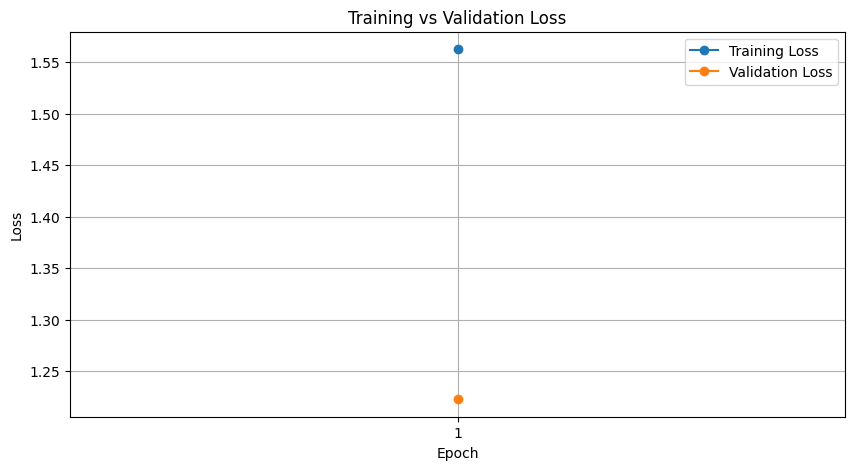

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.xticks(range(len(train_losses)), range(1, len(train_losses) + 1))  # Set x-axis ticks to represent epochs
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
def evaluate_model(model, data_loader, device, tokenizer):
    model.eval()
    all_start_preds = []
    all_end_preds = []
    all_start_positions = []
    all_end_positions = []

    total_exact_match = 0
    total_f1 = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            # Forward pass: output from model is a tuple (start_logits, end_logits)
            start_logits, end_logits = model(input_ids, attention_mask=attention_mask)

            # Convert logits to start/end positions (argmax)
            start_preds = torch.argmax(start_logits, dim=1)
            end_preds = torch.argmax(end_logits, dim=1)

            all_start_preds.extend(start_preds.cpu().numpy())
            all_end_preds.extend(end_preds.cpu().numpy())
            all_start_positions.extend(start_positions.cpu().numpy())
            all_end_positions.extend(end_positions.cpu().numpy())

            # Calculate Exact Match (EM) and F1 score
            for i in range(len(start_preds)):
                start_pred = start_preds[i].item()
                end_pred = end_preds[i].item()
                start_true = start_positions[i].item()
                end_true = end_positions[i].item()

                # Exact Match: Check if both start and end positions match
                if start_pred == start_true and end_pred == end_true:
                    total_exact_match += 1

                # F1 score calculation
                total_f1 += compute_f1_score(start_pred, end_pred, start_true, end_true, tokenizer)

            total_samples += len(start_preds)

    # Compute final scores
    exact_match = total_exact_match / total_samples
    f1_score = total_f1 / total_samples
    return exact_match, f1_score


In [43]:
def compute_f1_score(start_pred, end_pred, start_true, end_true, tokenizer):
    # Convert start and end indices to predicted and true answers
    predicted_answer_tokens = tokenizer.convert_ids_to_tokens(start_pred + end_pred)
    true_answer_tokens = tokenizer.convert_ids_to_tokens(start_true + end_true)

    # Convert tokens to sets for comparison
    predicted_tokens = set(predicted_answer_tokens)
    true_tokens = set(true_answer_tokens)

    # Calculate F1 score
    intersection = predicted_tokens.intersection(true_tokens)
    precision = len(intersection) / len(predicted_tokens) if predicted_tokens else 0
    recall = len(intersection) / len(true_tokens) if true_tokens else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return f1_score


In [44]:
em, f1 = evaluate_model(model, val_loader, device, tokenizer)
print(f"Exact Match: {em:.4f}")
print(f"F1 Score: {f1:.4f}")


Exact Match: 0.5196
F1 Score: 0.9262


In [45]:
def encode_sample(sample, tokenizer, max_len=384):

    # Extract question, context, and answer
    question = sample["question"]
    context = sample["context"]
    answer_text = sample["answers"]["text"][0]

    # Encode the question, context, and answer
    inputs = tokenizer.encode_plus(
        question,
        context,
        add_special_tokens=True,  # Adds [CLS] and [SEP] tokens
        max_length=max_len,
        padding='max_length',  # Pads to max_len
        truncation=True,  # Truncates to max_len
        return_tensors="pt",  # Return PyTorch tensors
        return_attention_mask=True  # Includes attention mask
    )

    # Get the tokenized inputs
    input_ids = inputs["input_ids"].squeeze(0)  # Remove the batch dimension
    attention_mask = inputs["attention_mask"].squeeze(0)  # Remove batch dimension

    # Find the start and end positions of the answer in the context
    answer_start = context.find(answer_text)
    answer_end = answer_start + len(answer_text) - 1

    # Convert the tokenized answer indices into input_ids
    # Note: This part may need modification based on how your tokenizer splits the answer.
    start_position = input_ids.tolist().index(tokenizer.encode(answer_text, add_special_tokens=False)[0])
    end_position = start_position + len(tokenizer.encode(answer_text, add_special_tokens=False)) - 1

    # Return the encoded sample
    encoded = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "start_positions": start_position,
        "end_positions": end_position,
        "tokens": tokenizer.convert_ids_to_tokens(input_ids)  # Get the tokens for the input_ids
    }

    return encoded


In [46]:
sample = train_data[0]  # Example from your dataset
encoded_sample = encode_sample(sample, tokenizer)

input_ids = encoded_sample["input_ids"]
attention_mask = encoded_sample["attention_mask"]
start_positions = encoded_sample["start_positions"]
end_positions = encoded_sample["end_positions"]
tokens = encoded_sample["tokens"]

# Print the encoded tokens
print("Tokens:", tokens)
print("Start Position:", start_positions)
print("End Position:", end_positions)


Tokens: ['[CLS]', 'to', 'whom', 'did', 'the', 'virgin', 'mary', 'allegedly', 'appear', 'in', '1858', 'in', 'lou', '##rdes', 'france', '?', '[SEP]', 'architectural', '##ly', ',', 'the', 'school', 'has', 'a', 'catholic', 'character', '.', 'atop', 'the', 'main', 'building', "'", 's', 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'virgin', 'mary', '.', 'immediately', 'in', 'front', 'of', 'the', 'main', 'building', 'and', 'facing', 'it', ',', 'is', 'a', 'copper', 'statue', 'of', 'christ', 'with', 'arms', 'up', '##rai', '##sed', 'with', 'the', 'legend', '"', 've', '##ni', '##te', 'ad', 'me', 'om', '##nes', '"', '.', 'next', 'to', 'the', 'main', 'building', 'is', 'the', 'basilica', 'of', 'the', 'sacred', 'heart', '.', 'immediately', 'behind', 'the', 'basilica', 'is', 'the', 'gr', '##otto', ',', 'a', 'marian', 'place', 'of', 'prayer', 'and', 'reflection', '.', 'it', 'is', 'a', 'replica', 'of', 'the', 'gr', '##otto', 'at', 'lou', '##rdes', ',', 'france', 'where', 'the', 'virgin', 

In [52]:
# Sample for testing or validation
sample = train_data[17]  # Choose any sample #3500 #5000 #1068
encoded = encode_sample(sample, tokenizer)

# Convert to tensors and move to device
input_ids = torch.tensor(encoded["input_ids"]).unsqueeze(0).to(device)  # Add batch dimension and move to device
attention_mask = torch.tensor(encoded["attention_mask"]).unsqueeze(0).to(device)  # Same for attention_mask

# Pass through the model (inference example)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    start_logits, end_logits = model(input_ids, attention_mask=attention_mask)

# Get the predicted answer indices
start_idx = torch.argmax(start_logits, dim=1).item()
end_idx = torch.argmax(end_logits, dim=1).item()

# Handle edge cases (if the model predicts end < start, adjust the end index)
if end_idx < start_idx:
    end_idx = start_idx

# Extract tokens from the encoded list using the start and end indices
predicted_tokens = encoded["tokens"][start_idx:end_idx + 1]  # Extract tokens based on the indices

# Join tokens to form the final predicted answer
predicted_answer = " ".join(predicted_tokens).replace(" ##", "")  # Clean up any subword tokens

# Extract only the portion of the answer after the SEP token
if "[SEP]" in predicted_answer:
    predicted_answer = predicted_answer.split("[SEP]")[-1].strip()  # Take only the part after SEP

# Print the results (only the answer after the SEP token)
print("Question:", sample["question"])
print("True Answer:", sample["answers"]["text"][0])  # True answer from the dataset
print("Predicted Answer:", predicted_answer)  # Predicted answer from the model
print("\n\n\n\n\n")

Question: Before the creation of the College of Engineering similar studies were carried out at which Notre Dame college?
True Answer: the College of Science
Predicted Answer: college of science








<ipython-input-52-d171b7ae88ba>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded["input_ids"]).unsqueeze(0).to(device)  # Add batch dimension and move to device
<ipython-input-52-d171b7ae88ba>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(encoded["attention_mask"]).unsqueeze(0).to(device)  # Same for attention_mask


In [48]:
decoded_span = tokenizer.decode(encoded["input_ids"][encoded["start_positions"]:encoded["end_positions"]+1])
print("Decoded Span:", decoded_span)
print("True Answer:", sample["answers"]["text"][0])



Decoded Span: wikileaks
True Answer: WikiLeaks
